In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/

Mounted at /content/gdrive
/content/gdrive/My Drive


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/CS 4782 Final Project')

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import torchvision
from torchvision import models
from torchvision.utils import save_image
import numpy as np
from math import log10
import matplotlib.pyplot as plt

In [4]:
class VGG16_perceptual(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16_perceptual, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 4):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 14):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(14, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_1 = h
        h = self.slice2(h)
        h_relu1_2 = h
        h = self.slice3(h)
        h_relu3_2 = h
        h = self.slice4(h)
        h_relu4_2 = h
        return h_relu1_1, h_relu1_2, h_relu3_2, h_relu4_2

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
import pickle
import numpy as np


class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5)
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)

class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False, downscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        if downscale:
            self.downscale = Downscale2d()
        else:
            self.downscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5)
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul

        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)

        downscale = self.downscale
        intermediate = self.intermediate
        if downscale is not None and min(x.shape[2:]) >= 128:
            w = self.weight * self.w_mul
            w = F.pad(w, (1,1,1,1))
            w = (w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1])*0.25 # avg_pool?
            x = F.conv2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
            downscale = None
        elif downscale is not None:
            assert intermediate is None
            intermediate = downscale

        if not have_convolution and intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)

        if intermediate is not None:
            x = intermediate(x)

        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None

    def forward(self, x, noise=None):
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x

class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)

    def forward(self, x, latent):
        style = self.lin(latent)
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x

class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)


class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride

    def forward(self, x):
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x

def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        return upscale2d(x, factor=self.factor, gain=self.gain)


class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))

    def forward(self, x):
        x = super().forward(x)
        x = x.unsqueeze(1).expand(-1, 18, -1)
        return x

class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)

class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):
        x = self.top_epi(x)
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x


class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale)
        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)

    def forward(self, dlatents_in_range):
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.out_channels = out_channels
        self.use_noise = use_noise
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale, intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)

    def forward(self, x, dlatents_in_range, noise=None):
        x = self.conv0_up(x)
        if self.use_noise and noise is not None:
            noise = F.interpolate(noise, size=x.shape[2:], mode='bilinear', align_corners=False)
            x = x + noise
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,
        num_channels        = 3,
        resolution          = 1024,
        fmap_base           = 8192,
        fmap_decay          = 1.0,
        fmap_max            = 512,
        use_styles          = True,
        const_input_layer   = True,
        use_noise           = True,
        randomize_noise     = True,
        nonlinearity        = 'lrelu',
        use_wscale          = True,
        use_pixel_norm      = False,
        use_instance_norm   = True,
        dtype               = torch.float32,
        fused_scale         = 'auto',
        blur_filter         = [1,2,1],
        structure           = 'auto',
        is_template_graph   = False,
        force_clean_graph   = False,


        ):

        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size

        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4
        if is_template_graph: force_clean_graph = True
        if force_clean_graph: randomize_noise = False
        if structure == 'auto': structure = 'linear' if force_clean_graph else 'recursive'

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))

            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels,num_channels, 1,gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))

    def forward(self, dlatents_in, noises=None):
        results = None
        noise_index = 0

        for i, m in enumerate(self.blocks.values()):
            if i == 0 and isinstance(m, InputBlock):
                results = m(dlatents_in[:, 2*i:2*i+2])
            elif isinstance(m, GSynthesisBlock) and m.use_noise:
                current_noise = noises[noise_index] if noises is not None else None
                results = m(results, dlatents_in[:, 2*i:2*i+2], noise=current_noise)
                noise_index += 1
            else:
                results = m(results, dlatents_in[:, 2*i:2*i+2])

        rgb = self.torgb(results)
        return rgb

class StddevLayer(nn.Module):
    def __init__(self, group_size=4, num_new_features=1):
        super().__init__()
        self.group_size = 4
        self.num_new_features = 1
    def forward(self, x):
        b, c, h, w = x.shape
        group_size = min(self.group_size, b)
        y = x.reshape([group_size, -1, self.num_new_features,
                        c // self.num_new_features, h, w])
        y = y - y.mean(0, keepdim=True)
        y = (y**2).mean(0, keepdim=True)
        y = (y + 1e-8)**0.5
        y = y.mean([3, 4, 5], keepdim=True).squeeze(3)
        y = y.expand(group_size, -1, -1, h, w).clone().reshape(b, self.num_new_features, h, w)
        z = torch.cat([x, y], dim=1)
        return z

class Downscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.factor = factor
        self.gain = gain
        if factor == 2:
            f = [np.sqrt(gain) / factor] * factor
            self.blur = BlurLayer(kernel=f, normalize=False, stride=factor)
        else:
            self.blur = None

    def forward(self, x):
        assert x.dim()==4
        if self.blur is not None and x.dtype == torch.float32:
            return self.blur(x)

        if self.gain != 1:
            x = x * self.gain

        if factor == 1:
            return x

        return F.avg_pool2d(x, self.factor)

class DiscriminatorBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, gain, use_wscale, activation_layer):
        super().__init__(OrderedDict([
            ('conv0', MyConv2d(in_channels, in_channels, 3, gain=gain, use_wscale=use_wscale)),
            ('act0', activation_layer),
            ('blur', BlurLayer()),
            ('conv1_down', MyConv2d(in_channels, out_channels, 3, gain=gain, use_wscale=use_wscale, downscale=True)),
            ('act1', activation_layer)]))

class View(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class DiscriminatorTop(nn.Sequential):
    def __init__(self, mbstd_group_size, mbstd_num_features, in_channels, intermediate_channels, gain, use_wscale, activation_layer, resolution=4, in_channels2=None, output_features=1, last_gain=1):
        layers = []
        if mbstd_group_size > 1:
            layers.append(('stddev_layer', StddevLayer(mbstd_group_size, mbstd_num_features)))
        if in_channels2 is None:
            in_channels2 = in_channels
        layers.append(('conv', MyConv2d(in_channels + mbstd_num_features, in_channels2, 3, gain=gain, use_wscale=use_wscale)))
        layers.append(('act0', activation_layer))
        layers.append(('view', View(-1)))
        layers.append(('dense0', MyLinear(in_channels2*resolution*resolution, intermediate_channels, gain=gain, use_wscale=use_wscale)))
        layers.append(('act1', activation_layer))
        layers.append(('dense1', MyLinear(intermediate_channels, output_features, gain=last_gain, use_wscale=use_wscale)))
        super().__init__(OrderedDict(layers))

class D_basic(nn.Sequential):

    def __init__(self,
        #images_in,
        #labels_in,
        num_channels        = 3,
        resolution          = 1024,
        fmap_base           = 8192,
        fmap_decay          = 1.0,
        fmap_max            = 512,
        nonlinearity        = 'lrelu',
        use_wscale          = True,
        mbstd_group_size    = 4,
        mbstd_num_features  = 1,
        #blur_filter         = [1,2,1],
                ):
        self.mbstd_group_size = 4
        self.mbstd_num_features = 1
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        self.gain = gain
        self.use_wscale = use_wscale
        super().__init__(OrderedDict([
            ('fromrgb', MyConv2d(num_channels, nf(resolution_log2-1), 1, gain=gain, use_wscale=use_wscale)),
            ('act', act)]
            +[('{s}x{s}'.format(s=2**res), DiscriminatorBlock(nf(res-1), nf(res-2), gain=gain, use_wscale=use_wscale, activation_layer=act)) for res in range(resolution_log2, 2, -1)]
            +[('4x4', DiscriminatorTop(mbstd_group_size, mbstd_num_features, nf(2), nf(2), gain=gain, use_wscale=use_wscale, activation_layer=act))]))




# Loading the pre-trained model

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all = nn.Sequential(OrderedDict([('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=1024))
    ]))

g_all.load_state_dict(torch.load('/content/gdrive/MyDrive/CS 4782 Final Project/karras2019stylegan-ffhq-1024x1024.pt', map_location=device))
g_all.eval()
g_all.to(device)
g_mapping, g_synthesis = g_all[0],g_all[1]

In [7]:
g_mapping, g_synthesis = g_all[0], g_all[1]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_synthesis = g_synthesis.to(device)

img_path = '/content/gdrive/MyDrive/CS 4782 Final Project/results/dave.png'
with open(img_path, "rb") as f:
    image = Image.open(f).convert("RGB")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((1024, 1024))
])
image = transform(image).unsqueeze(0).to(device)
print(image.shape)
img_path = '/content/gdrive/MyDrive/CS 4782 Final Project/results/davew.png'
with open(img_path, "rb") as f:
    image1 = Image.open(f).convert("RGB")

image1 = transform(image1).unsqueeze(0).to(device)

torch.Size([1, 3, 1024, 1024])


In [8]:
print(device)

cuda:0


In [9]:
for i in range(20):
  z = torch.randn(1,512,device = device)
  img = g_all(z)
  img = (img +1.0)/2.0
  save_image(img.clamp(0,1),"/content/gdrive/MyDrive/CS 4782 Final Project/Saved Images/random_SG4-{}.png".format(i+1))

In [10]:
def loss_function(syn_img, img, img_p, MSE_loss, upsample, perceptual):

  syn_img_p = upsample(syn_img)
  syn0, syn1, syn2, syn3 = perceptual(syn_img_p)
  r0, r1, r2, r3 = perceptual(img_p)
  mse = MSE_loss(syn_img,img)

  per_loss = 0
  per_loss += MSE_loss(syn0,r0)
  per_loss += MSE_loss(syn1,r1)
  per_loss += MSE_loss(syn2,r2)
  per_loss += MSE_loss(syn3,r3)

  #style loss added
  style_loss = MSE_loss(syn3,r3)

  return mse, per_loss

In [11]:
def PSNR(mse, flag = 0):
  if flag == 0:
    psnr = 10 * log10(1 / mse.item())
  return psnr

In [12]:

psnr_total = []

In [13]:
def initialize_noises(g_synthesis, device):
    noises = []
    for name, module in g_synthesis.named_modules():
        if isinstance(module, GSynthesisBlock) and module.use_noise:
            # Assuming module.conv0_up outputs the shape to which noise should conform
            example_output = torch.zeros(1, module.out_channels, 8, 8)  # Adjust 8x8 to the expected size based on your model
            noise_size = (example_output.size(0), example_output.size(1), example_output.size(2), example_output.size(3))
            noise = torch.randn(noise_size, device=device, requires_grad=True)
            noises.append(noise)
    return noises


In [14]:
def embedding_function(image, g_synthesis, device):
    upsample = torch.nn.Upsample(scale_factor=256/1024, mode='bilinear')
    img_p = upsample(image.clone())
    perceptual = VGG16_perceptual().to(device)
    MSE_loss = nn.MSELoss(reduction="mean")

    latents = torch.zeros((1, 18, 512), requires_grad=True, device=device)
    noises = initialize_noises(g_synthesis, device)
    optimizer_w = torch.optim.Adam([latents], lr=0.01, betas=(0.9, 0.999), eps=1e-8)
    optimizer_n = torch.optim.Adam(noises, lr=0.01, betas=(0.9, 0.999), eps=1e-8)

    loss_ = []
    loss_psnr = []

    for e in range(1500):
        print(e)
        optimizer_w.zero_grad()
        syn_img = g_synthesis(latents, noises)
        syn_img_p = (syn_img + 1.0) / 2.0
        mse, per_loss = loss_function(syn_img_p, image, img_p, MSE_loss, upsample, perceptual)
        psnr = PSNR(mse)
        loss = mse + per_loss
        loss.backward()
        optimizer_w.step()

        # Optimizing noise vectors
        optimizer_n.zero_grad()
        syn_img = g_synthesis(latents, noises)
        syn_img_p = (syn_img + 1.0) / 2.0
        mse, per_loss = loss_function(syn_img_p, image, img_p, MSE_loss, upsample, perceptual)
        loss = mse + per_loss
        loss.backward()
        optimizer_n.step()

        loss_np = loss.detach().cpu().numpy()
        loss_p = per_loss.detach().cpu().numpy()
        loss_m = mse.detach().cpu().numpy()
        loss_psnr.append(psnr)
        loss_.append(loss_np)

        print(loss)


        if (e + 1) % 500 == 0:
            print(f"iter {e + 1}: loss -- {loss_np}, mse_loss -- {loss_m}, percep_loss -- {loss_p}, psnr -- {psnr}")
            save_image(syn_img_p.clamp(0, 1), f"output_image{e + 1}.png")

    plt.plot(loss_, label='Loss = MSELoss + Perceptual')
    plt.plot(loss_psnr, label='PSNR')
    plt.legend()
    return latents, noises


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 189MB/s]


Streaming output truncated to the last 5000 lines.
tensor(1.9867, device='cuda:0', grad_fn=<AddBackward0>)
503
tensor(1.9641, device='cuda:0', grad_fn=<AddBackward0>)
504
tensor(1.9181, device='cuda:0', grad_fn=<AddBackward0>)
505
tensor(1.8725, device='cuda:0', grad_fn=<AddBackward0>)
506
tensor(1.8946, device='cuda:0', grad_fn=<AddBackward0>)
507
tensor(1.9402, device='cuda:0', grad_fn=<AddBackward0>)
508
tensor(1.8867, device='cuda:0', grad_fn=<AddBackward0>)
509
tensor(1.8860, device='cuda:0', grad_fn=<AddBackward0>)
510
tensor(1.8272, device='cuda:0', grad_fn=<AddBackward0>)
511
tensor(1.8048, device='cuda:0', grad_fn=<AddBackward0>)
512
tensor(1.7766, device='cuda:0', grad_fn=<AddBackward0>)
513
tensor(1.8210, device='cuda:0', grad_fn=<AddBackward0>)
514
tensor(1.8228, device='cuda:0', grad_fn=<AddBackward0>)
515
tensor(1.7837, device='cuda:0', grad_fn=<AddBackward0>)
516
tensor(1.7343, device='cuda:0', grad_fn=<AddBackward0>)
517
tensor(1.7519, device='cuda:0', grad_fn=<AddBackw

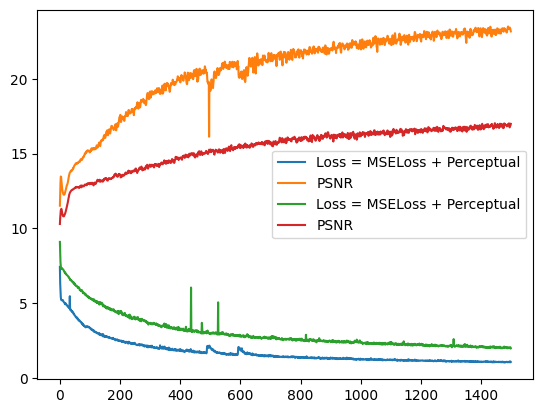

In [15]:
latent1, noises1 = embedding_function(image, g_synthesis, device)
latent2, noises2 = embedding_function(image1, g_synthesis, device)

In [17]:
with torch.no_grad():
    synthesized_image = g_synthesis(latent1, noises1)

In [22]:
# psnr_value = PSNR(synthesized_image)
# print(psnr_value)
# psnr_value = PSNR(image)
# print(psnr_value)
syn_img = (synthesized_image + 1.0) / 2.0
save_image(syn_img.clamp(0, 1), f"/content/gdrive/MyDrive/CS 4782 Final Project/results/PSNR.png")


In [ ]:
def loss_function_2(syn_img, img, img2, img_p,img_p2, MSE_loss, upsample, perceptual, MaskM,maskU,maskP,maskP2):

  syn_img_p = upsample(syn_img)
  syn0, syn1, syn2, syn3 = perceptual(syn_img_p)
  r0, r1, r2, r3 = perceptual(img_p)
  f0, f1, f2, f3 = perceptual(img_p2)
  m=maskM.to(device)
  u=maskU.to(device)
  p=maskP.to(device)
  p2=maskP2.to(device)
#
  mse1 = MSE_loss(m*syn_img,img)
  mse2 = MSE_loss((1-m)*syn_img,img2)
  per_loss = 0
  per_loss += MSE_loss(u*syn0,r0)
  per_loss += MSE_loss(u*syn1,r1)
  per_loss += MSE_loss(p2*syn2,r2)
  per_loss += MSE_loss(p*syn3,r3)
  per_loss /=4
  #style loss added
  style_loss = MSE_loss((1-p)*syn3,f3)

  return mse1, mse2, per_loss,style_loss

In [ ]:
def create_matrix_with_zeros(row_start, col_start, row_end, col_end):


    matrix = np.ones((1024, 1024), dtype=int)


    matrix[row_start:row_end+1, col_start:col_end+1] = 0

    return matrix

In [ ]:
def embedding_function_updated(image1,image2, g_synthesis, device, maskM,maskU,maskP,maskP2):
  #this is ithe updated image embeddings with the two images
  #note to self the paper x and y are the two images (not coordinates) because they want to be confusing ()
    upsample = torch.nn.Upsample(scale_factor=256/1024, mode='bilinear')

    img_p = upsample(image1.clone())
    img_p2 = upsample(image2.clone())


    perceptual = VGG16_perceptual().to(device)

    #maskM=maskM.to(device)
    MSE_loss = nn.MSELoss(reduction="mean")

    latents = torch.zeros((1, 18, 512), requires_grad=True, device=device)
    noises = initialize_noises(g_synthesis, device)
    optimizer_w = torch.optim.Adam([latents], lr=0.01, betas=(0.9, 0.999), eps=1e-8)
    optimizer_n = torch.optim.Adam(noises, lr=0.01, betas=(0.9, 0.999), eps=1e-8)

    loss_ = []
    loss_psnr = []

    for e in range(1500):
        print(e)
        optimizer_w.zero_grad()
        syn_img = g_synthesis(latents, noises)
        syn_img_p = (syn_img + 1.0) / 2.0
        mse1,mse_2, per_loss, style_loss = loss_function_2(syn_img_p, image1,image2, img_p,img_p2, MSE_loss, upsample, perceptual,maskM,maskU,maskP,maskP2)

        loss = mse1 + mse_2 + per_loss+style_loss

        loss.backward()
        optimizer_w.step()

        optimizer_n.zero_grad()
        syn_img = g_synthesis(latents, noises)
        syn_img_p = (syn_img + 1.0) / 2.0
        mse1,mse_2, per_loss, style_loss = loss_function_2(syn_img_p, image1,image2, img_p,img_p2, MSE_loss, upsample, perceptual,maskM,maskU,maskP,maskP2)


        loss = mse1 + mse_2 + per_loss+style_loss
        #psnr = PSNR(mse1)

        loss.backward()
        optimizer_n.step()

        loss_np = loss.detach().cpu().numpy()
        loss_p = per_loss.detach().cpu().numpy()
        loss_m = mse1.detach().cpu().numpy()

        loss_.append(loss_np)

        print(loss)


        if (e + 1) % 500 == 0:
            print(f"iter {e + 1}: loss -- {loss_np}, mse_loss -- {loss_m}, percep_loss -- {loss_p}")
            save_image(syn_img_p.clamp(0, 1), f"output_image{e + 1}.png")

    plt.plot(loss_, label='Loss = MSELoss + Perceptual')
    plt.plot(loss_psnr, label='PSNR')
    plt.legend()
    return latents, noises


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.0MB/s]


0
tensor(4.9907, device='cuda:0', grad_fn=<AddBackward0>)
1
tensor(4.6542, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(4.4278, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(4.2983, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(4.2004, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(4.1360, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(4.0805, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(4.0571, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(4.1039, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(4.0815, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(4.0454, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(4.0726, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(4.0504, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(4.0787, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(4.0476, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(4.0335, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(4.0362, device='cuda:0', grad_fn=<AddBackward0>)
17
tens

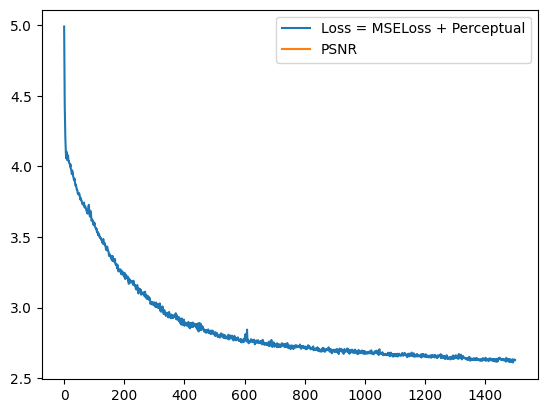

In [ ]:
maskM= np.ones((1024, 1024), dtype=int)


maskM[0:1024, 0:512] = 0
maskM=torch.from_numpy(maskM)
maskU = np.ones((256, 256), dtype=int)


maskU[0:256, 0:128] = 0
maskU=torch.from_numpy(maskU)

maskP2 = np.ones((64, 64), dtype=int)
maskP2[0:64, 0:32] = 0
maskP2=torch.from_numpy(maskP2)

maskP = np.ones((32, 32), dtype=int)
maskP[0:32, 0:16] = 0
maskP=torch.from_numpy(maskP)



latent2, noises2 = embedding_function_updated (image,image1, g_synthesis, device,maskM,maskU,maskP,maskP2)


In [ ]:
for i in range(20):
    a = (1/20) * i
    w = latent1 * (1 - a) + latent2 * a
    syn_img = g_synthesis(w, noises1)
    syn_img = (syn_img + 1.0) / 2.0
    save_image(syn_img.clamp(0, 1), f"/content/gdrive/MyDrive/CS 4782 Final Project/Saved Images/gen7{i}.png")


In [ ]:
syn_img = g_synthesis(latent2,noises2)
syn_img = (syn_img + 1.0) / 2.0
save_image(syn_img.clamp(0, 1), f"/content/gdrive/MyDrive/CS 4782 Final Project/results/chetty{4}.png")

In [ ]:
def embedding_Hierarchical(image):
  upsample = torch.nn.Upsample(scale_factor = 256/1024, mode = 'bilinear')
  img_p = image.clone()
  img_p = upsample(img_p)

  perceptual = VGG16_perceptual().to(device)

  MSE_loss = nn.MSELoss(reduction="mean")
  latent_w = torch.zeros((1,512), requires_grad = True, device = device)

  optimizer = optim.Adam({latent_w},lr=0.01,betas=(0.9,0.999),eps=1e-8)


  loss_ = []
  loss_psnr = []
  for e in range(1000):
    optimizer.zero_grad()
    latent_w1 = latent_w.unsqueeze(1).expand(-1, 18, -1)
    syn_img = g_synthesis(latent_w1)
    syn_img = (syn_img+1.0)/2.0
    mse, per_loss = loss_function(syn_img, image, img_p, MSE_loss, upsample, perceptual)
    psnr = PSNR(mse, flag = 0)
    loss = per_loss +mse
    loss.backward()
    optimizer.step()
    loss_np=loss.detach().cpu().numpy()
    loss_p=per_loss.detach().cpu().numpy()
    loss_m=mse.detach().cpu().numpy()
    loss_psnr.append(psnr)
    loss_.append(loss_np)
    if (e+1)%500==0 :
      print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}, psnr --{}".format(e+1,loss_np,loss_m,loss_p,psnr))
      save_image(syn_img.clamp(0,1),"Hier_pass_morphP1-{}.png".format(e+1))


  latent_w1 = latent_w.unsqueeze(1).expand(-1, 18, -1)
  latent_w1 = torch.tensor(latent_w1, requires_grad=True)
  optimizer = optim.Adam({latent_w1},lr=0.01,betas=(0.9,0.999),eps=1e-8)
  for e in range(1000):
    optimizer.zero_grad()
    syn_img = g_synthesis(latent_w1)
    syn_img = (syn_img+1.0)/2.0
    mse, per_loss = loss_function(syn_img, image, img_p, MSE_loss, upsample, perceptual)
    psnr = PSNR(mse, flag = 0)
    loss = per_loss +mse
    loss.backward()
    optimizer.step()
    loss_np=loss.detach().cpu().numpy()
    loss_p=per_loss.detach().cpu().numpy()
    loss_m=mse.detach().cpu().numpy()
    loss_psnr.append(psnr)
    loss_.append(loss_np)
    if (e+1)%500==0 :
      print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}, psnr --{}".format(e+1,loss_np,loss_m,loss_p,psnr))
      save_image(syn_img.clamp(0,1),"Hier_pass_morphP2-{}.png".format(e+1))


  plt.plot(loss_, label = 'Loss = MSELoss + Perceptual')
  plt.plot(loss_psnr, label = 'PSNR')
  plt.legend()
  return latent_w1

iter500: loss -- 5.27646017074585,  mse_loss --0.034349218010902405,  percep_loss --5.242110729217529, psnr --14.64083145574322
iter1000: loss -- 5.166117191314697,  mse_loss --0.0341561995446682,  percep_loss --5.131960868835449, psnr --14.665304579069167


<ipython-input-21-dcb23cc3f5f6>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w1 = torch.tensor(latent_w1, requires_grad=True)


iter500: loss -- 3.4462268352508545,  mse_loss --0.021002713590860367,  percep_loss --3.4252240657806396, psnr --16.777245899612495
iter1000: loss -- 2.976651191711426,  mse_loss --0.017298787832260132,  percep_loss --2.959352493286133, psnr --17.61984327865685
iter500: loss -- 3.1713545322418213,  mse_loss --0.023325737565755844,  percep_loss --3.14802885055542, psnr --16.32164614862344
iter1000: loss -- 2.7055253982543945,  mse_loss --0.016866587102413177,  percep_loss --2.6886587142944336, psnr --17.729727865595716
iter500: loss -- 1.3345760107040405,  mse_loss --0.006344537250697613,  percep_loss --1.3282314538955688, psnr --21.976000483994376
iter1000: loss -- 1.1371427774429321,  mse_loss --0.0050987908616662025,  percep_loss --1.1320439577102661, psnr --22.925328012286524


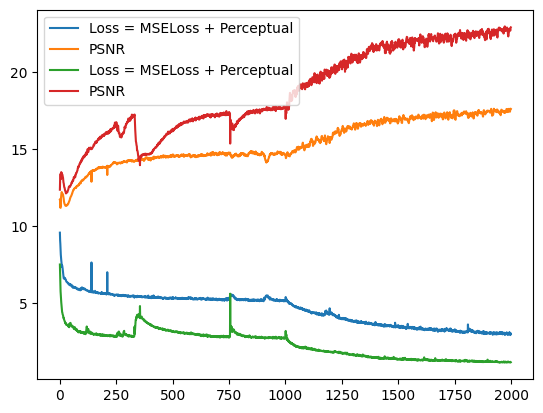

In [ ]:
latent1 = embedding_Hierarchical(image)
latent2 = embedding_Hierarchical(image1)

In [ ]:
for i in range(20):
  a = (1/20)*i
  w = latent2 * (1-a)+ latent1 * a
  syn_img = g_synthesis(w)
  syn_img = (syn_img+1.0)/2.0
  save_image(syn_img.clamp(0,1),"/content/gdrive/MyDrive/CS 4782 Final Project/Hier-Morphed2{}.png".format(i))